# Hacking CAPTCHAs using Machine Learning (II)
### Pre-Trained Long-Short Term Memory Neural Network
**by: Pablo Mateo**

# Situación Inicial
Queremos crear un sistema automatizado para registrar usuarios en una web.<br>
Para ello vamos a utilizar diversas técnicas.<br>
Vamos a crear un script que utilice **Web Scrapping** para extraer la información de un formulario y lo rellene.

# Problema
El formulario cuenta con un campo **CAPTCHA** que se debe completar obligatoriamente.<br>
Por ello, debemos crear algún sistema que permita "leer" la imagen y rellenar dicho campo.<br>

# Solución

Vamos a utilizar una **LSTM Neural Network** que descifre el texto contenido en el CAPTCHA utilizando **OCR - Optical Character Recognition**.<br>
En este caso, utilizamos una red pre-entrenada con 400.000 caracteres y 100 idiomas realizada por **HP** y posteriormente por **Google** y conocida como **Tesseract OCR Engine**.<br>
[Tesseract Link](https://github.com/tesseract-ocr/tesseract)

## Importante
Dicha red está entrenada con textos claros y legibles. En este ejemplo, los CAPTCHAS se encuentran ligeramente distorsionados y con un fondo que complica su lectura. Por ello, vamos a utilizar diversas técnicas para mejorar la imagen que pasaremos posteriormente a la red.

**Example URL**: http://example.webscraping.com/places/default/user/register?_next=%2Fplaces%2Fdefault%2Fedit%2FSpain-213

![title](OCR/imagesNotebook/register_form.png)

## Código
Creamos un método para extraer la información de la petición al formulario en formato **JSON**

In [1]:
from lxml.html import fromstring

def parse_form(html):
    tree = fromstring(html)
    data = {}
    for e in tree.cssselect('form input'):
        if e.get('name'):
            data[e.get('name')] = e.get('value')
    return data


## Código
Iniciamos una sesión con el servidor y utlizamos el método anterior para parsear la información necesaria.<br>
Comprobamos que tenemos los siguientes campos:
 - Nombre
 - Apellido
 - Email
 - Contraseña
 - Confirmar contraseña
 - CAPTCHA
  

In [2]:
import requests
import json

REGISTER_URL = 'http://example.webscraping.com/places/default/user/register?_next=%2Fplaces%2Fdefault%2Fedit%2FSpain-213'

session = requests.Session()
html = session.get(REGISTER_URL)
form = parse_form(html.content)

print(json.dumps(form, indent=2))

{
  "first_name": "",
  "last_name": "",
  "email": "",
  "password": "",
  "password_two": "",
  "recaptcha_response_field": null,
  "_next": "/places/default/edit/Spain-213",
  "_formkey": "8f92ebea-b84d-4f5a-9287-7b3cbca3ebd4",
  "_formname": "register"
}


## Código
Creamos un método para extraer únicamente la imagen del CAPTCHA.<br>
Para ello, usamos la etiqueta **div** del código **HTML** de la imagen.<br>

![title](OCR/imagesNotebook/web_div_captcha.png)

Como podemos comprobar, el texto se encuentra sobre un fondo para complicar su análisis de forma automatizada.

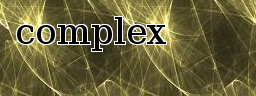

In [3]:
from io import BytesIO
from lxml.html import fromstring
from PIL import Image
import base64

def get_captcha_img(html):
    tree = fromstring(html)
    img_data = tree.cssselect('div#recaptcha img')[0].get('src')
    img_data = img_data.partition(',')[-1]
    binary_img_data = base64.b64decode(img_data)
    img = Image.open(BytesIO(binary_img_data))
    return img

get_captcha_img(html.content)

## Código
Pasamos esta imagen a **Tesseract** y analizamos su texto.<br>
Recordemos que se trata de una red neuronal pre-entrenada.<br><br>
**Importante**<br>
Cada vez que se ejecuta este código se analiza una imagen diferente.<br>
Puede darse la casualidad de que detecte el texto a la perfección. No suele ser lo habitual.<br>
En ese caso, no sería necesario el siguiente paso, pero como la red no tiene forma de comprobar si su análisis es correcto, es conveniente implementarlo de todas formas.<br>

**Output**<br>
Existen 3 posibilidades:<br>
- Que la red detecte una palabra pero esta esté mal.
- Que la red detecte correctamente la palabra.
- Que la red no sea capaz de detectar la palabra del CAPTCHA utilizando sus diccionarios pre-entrenados, devolviendo entonces un **String vacío**.

In [4]:
import pytesseract
img = get_captcha_img(html.content)
stringDetected = pytesseract.image_to_string(img)
if stringDetected == '':
    print("No se ha detectado ningún texto en la imagen")
else:
    print("String detectado: {}".format(stringDetected))

No se ha detectado ningún texto en la imagen


## Código
Salvo que la palabra sea detectada correctamente, lo cual es poco probable, vamos a modificar la imagen para que muestre el texto de la forma más similar posible al input usado como valores de entrenamiento de la red.<br><br>
Para ello, primero vamos a convertir la imagen a **escala de grises**.<br>
Después, vamos a modificar el **Threshold** de la imagen. Iteramos por cada uno de los pixels y nos quedamos con aquellos que sean muy próximos a 1 (negro), haciendo que el resto se conviertan en blanco (255).<br><br>
En la carpeta del proyecto se pueden estas imagénes generadas:<br>
- **captcha_original.png** -> Imagen original.
- **captcha_gray.png** -> Imagen modificada a escala de grises.
- **captcha_thresholded.png** -> Imagen modificada usando el Threshold.

In [5]:
img.save('OCR/generatedImages/captcha_original.png')
gray = img.convert('L')
gray.save('OCR/generatedImages/captcha_gray.png')
bw = gray.point(lambda x: 0 if x < 1 else 255, '1')
bw.save('OCR/generatedImages/captcha_thresholded.png')

## Código
Repetimos el proceso de análisis pero en esta ocasión utilizando la imagen modificada.<br>
Al final del ejercicio comprobamos el nivel de acierto de esta técnica sobre una muestra de 100 ejemplos.<br>
En pruebas anteriores, esta técnica ha demostrado un nivel de efectividad del **92%**.

In [6]:
newStringDetected = pytesseract.image_to_string(bw)
print("String detectado tras modificación:")
print("{}".format(newStringDetected))

String detectado tras modificación:
complex


## Código
Comprobado que funciona, aislamos el método de conversión de imagen para utilizarlo en nuestro script.

In [7]:
def img_to_bw(img):
    gray = img.convert('L')
    bw = gray.point(lambda x: 0 if x < 1 else 255, '1')
    return bw

# Script de Registro Automatizado
Tras las pruebas anteriores, creamos un script que nos registrará en la web.<br>
Si todo funciona, veremos un mensaje indicativo.<br>
De esta forma sólo tenemos que pasar los datos del usuario al que queremos registrar para hacerlo.<br>
En caso de que queramos bypasear el formulario de forma masiva, sólo tendríamos que usar un listado de usuarios.

In [8]:
import string

def register(first_name, last_name, email, password):
    session = requests.Session()
    html = session.get(REGISTER_URL)
    form = parse_form(html.content)
    form['first_name'] = first_name
    form['last_name'] = last_name
    form['email'] = email
    form['password'] = form['password_two'] = password
    img = get_captcha_img(html.content)
    captcha = ocr(img)
    form['recaptcha_response_field'] = captcha
    resp = session.post(html.url, form)
    success = '/user/register' not in resp.url
    if not success:
        form_errors = fromstring(resp.content).cssselect('div.error')
        print('Form Errors:')
        print('\n'.join(
            ('  {}: {}'.format(f.get('id'), f.text) for f in form_errors)))
    if success:
        print("¡Usuario Registrado correctamente!")
        print("Datos de registro:")
        print("\t Nombre: {}".format(first_name))
        print("\t Apellido: {}".format(last_name))
        print("\t Email: {}".format(email))
        print("\t Contraseña: {}".format(password))
        print("\t CAPTCHA: {}".format(captcha))
    return success


def ocr(img):
    bw = img_to_bw(img)
    captcha = pytesseract.image_to_string(bw)
    cleaned = ''.join(c for c in captcha.lower() if c in string.ascii_lowercase)
    if len(cleaned) != len(captcha):
        print('Caracteres mal detectados: {}'.format(set(captcha) - set(cleaned)))
    return cleaned


## Código
¡Probamos a registrar a un usuario!

In [9]:
register("test", "test", "eamil7@test.com", "1234")

¡Usuario Registrado correctamente!
Datos de registro:
	 Nombre: test
	 Apellido: test
	 Email: eamil7@test.com
	 Contraseña: 1234
	 CAPTCHA: woman


True

# Validación
Una vez comprobado que funciona y que somos capaces de **Hackear la validación por CAPTCHA**, vamos a comprobar cómo de efectivo es nuestro sistema haciéndolo.<br>
Para ello, y con idea de que no sea muy largo, he guardado en una carpeta **100 imágenes** generadas por el algoritmo del CAPTCHA junto con un documento **csv** en el que se muestra la solución de cada una.<br>
Usaremos esta pequeña muestra para testear la efectividad.<br><br>

Básicamente el sistema analiza cada imagen, determina qué texto es el que muestra y lo compara con la respuesta del documento excel. Si coinciden, habrá acertado, en caso contrario, habrá fallado.<br>
Para darse por válido, la respuesta debe coincidir al 100%.

In [10]:
import os
from PIL import Image
from csv import reader

SAMPLES_DIR = os.path.join(
    os.path.dirname(os.path.abspath('')),
    'JupyterNotebooksCode', 'OCR', 'captcha_samples')


def get_rdr(samples_folder=SAMPLES_DIR):
    return reader(open(os.path.join(samples_folder, 'samples.csv')))


def test_samples(samples_folder=SAMPLES_DIR):
    rdr = get_rdr(samples_folder=samples_folder)
    results = {'Correcto': 0, 'Incorrecto': 0}
    for fname, txt in rdr:
        img = Image.open(os.path.join(samples_folder, fname))
        captcha = ocr(img)
        if captcha == txt:
            results['Correcto'] += 1
        else:
            results['Incorrecto'] += 1
    print('Efectividad: {}%'.format(results['Correcto'] / 100.0))
    print('Resultados Obtenidos en el Test: ', results)
    print("")
    print("---------\n")
    print("Nuestro sistema es capaz de descifrar el CAPTCHA en un: {}% de las ocasiones\n".format(results['Correcto']))
    print("---------")
    return results

In [11]:
test_samples()

Caracteres mal detectados: {'8', 'H', '4'}
Caracteres mal detectados: {' ', '-'}
Caracteres mal detectados: {'‘'}
Caracteres mal detectados: {' ', '_'}
Efectividad: 0.92%
Resultados Obtenidos en el Test:  {'Correcto': 92, 'Incorrecto': 8}

---------

Nuestro sistema es capaz de descifrar el CAPTCHA en un: 92% de las ocasiones

---------


{'Correcto': 92, 'Incorrecto': 8}